In [2]:
%load_ext autoreload
%autoreload 2

import warnings

warnings.filterwarnings("ignore")

In [3]:
seed = 85

In [4]:
from typing import Callable

import gymnax

import jax
import jax.numpy as jnp
import jax.random as jr
from jax import lax
from jax import nn as jnn
import jax.tree_util as jtu

from tqdm import tqdm

In [5]:
import numpy as np
import seaborn as sns
from matplotlib import colors
from PIL import Image


def render(observation):
    cmap = sns.color_palette("cubehelix", observation.shape[-1])
    cmap.insert(0, (0, 0, 0))
    cmap = colors.ListedColormap(cmap)
    bounds = [i for i in range(observation.shape[-1] + 2)]
    norm = colors.BoundaryNorm(bounds, observation.shape[-1] + 1)
    numerical_state = np.amax(observation * np.reshape(np.arange(observation.shape[-1]) + 1, (1, 1, -1)), 2) + 0.5
    img = cmap(norm(numerical_state))
    return img[:, :, :3]


resize = lambda x: jnp.array(Image.fromarray((x * 255).astype(jnp.uint8)).resize((64, 64), Image.NEAREST))

In [6]:
def plan(
    state: jnp.ndarray,
    rollout_fn: Callable,
    action_dim: int,
    key: jr.PRNGKey,
    num_steps: int = 10,
    num_samples: int = 30,
    topk_ratio: float = 1.0,
    alpha: float = 1.0,
    temperature: float = 10,
    normalize: bool = True,
    iters: int = 12,
):
    topk = int(jnp.ceil(topk_ratio * num_samples))

    probs = jnp.full((num_steps, num_samples, action_dim), 1.0 / action_dim)
    state = jtu.tree_map(lambda x: jnp.repeat(x[None], num_samples, axis=0), state)
    for _ in range(iters):
        key, subkey = jr.split(key)
        actions = jr.categorical(subkey, jnp.log(probs + 1e-9))
        states, rewards = rollout_fn(state, actions[..., None])
        probs, r_top = _refit(probs, actions, rewards, topk, alpha, temperature, normalize)

    return probs, states, rewards


def _refit(probs, actions, rewards, topk, alpha, temperature=10, normalize=True):
    T, B, A = probs.shape

    cum_rewards = rewards.sum(0).squeeze(-1)[None]
    if normalize:
        cum_rewards = min_max_normalization(cum_rewards)

    topk_indices = jnp.argsort(-cum_rewards, axis=-1)[..., :topk]
    a_top = jnp.take_along_axis(actions, topk_indices, axis=-1)
    r_top = jnp.take_along_axis(cum_rewards, topk_indices, axis=-1)

    # match moment
    w = jnn.softmax(temperature * r_top, axis=-1)[..., None]
    one_hot_actions = jax.nn.one_hot(a_top, A)
    counts = jnp.sum(w * one_hot_actions, axis=1)
    probs_new = counts / counts.sum(axis=-1, keepdims=True)

    probs_new = jnp.expand_dims(probs_new, axis=1).repeat(B, axis=1)
    probs_updated = alpha * probs_new + (1 - alpha) * probs
    return probs_updated, r_top


def min_max_normalization(v: jnp.ndarray, dim: int = -1):
    v_max = v.max(dim, keepdims=True)
    v_min = v.min(dim, keepdims=True)

    v_norm = jnp.where(v_max != v_min, (v - v_min) / (v_max - v_min), v)
    return v_norm


def get_space_dim(space):
    dim = None
    try:
        dim = f"disc {space.n}"
    except:
        dim = f"cont {space.shape}"
    return dim


def gymnax_rollout(vmap_step, params, x0, actions, vmap_keys):
    """gymnax rollout"""

    def scan_fn(carry, u_t):
        state = carry
        n_obs, n_state, reward, done, _ = vmap_step(vmap_keys, state, u_t.squeeze(-1), params)
        return n_state, (n_obs, reward * (done == False))

    _, (obs, rewards) = lax.scan(scan_fn, x0, actions)
    return obs, rewards[..., None]


def simulate(env, env_params, max_steps=10, horizon=10, num_samples=30, iters=8, seed=0):
    rng = jr.PRNGKey(seed)
    rng, key_reset, key_step, key_plan = jr.split(rng, 4)
    key_rollout = jr.split(key_plan, num_samples)

    # setup planner
    action_dim = env.action_space(env_params).n
    vmap_step = jax.vmap(env.step, in_axes=(0, 0, 0, None))
    rollout_fn = lambda x, u: gymnax_rollout(vmap_step, env_params, x, u, key_rollout)

    obs, state = env.reset(key_reset, env_params)

    data = {"obs": [], "act": [], "rwd": [], "done": []}
    bar = tqdm(range(max_steps))
    for t in bar:
        action_probs, _, _ = plan(
            state,
            rollout_fn,
            action_dim,
            key_plan,
            num_steps=horizon,
            num_samples=num_samples,
            iters=iters,
        )
        action = action_probs.mean(1).argmax(-1)[0]
        next_obs, next_state, reward, done, _ = env.step(key_step, state, action, env_params)

        data["obs"].append(obs)
        data["act"].append(action)
        data["rwd"].append(reward)
        data["done"].append(done)

        state = next_state
        obs = next_obs

        if done:
            jax.clear_caches()
            break

    data = {k: jnp.stack(v, axis=0) for k, v in data.items()}
    return data

In [7]:
env_name = "Breakout-MinAtar"
env, env_params = gymnax.make(env_name)
n_actions = env.action_space(env_params).n
print("env name", env_name)
print("obs space", env.observation_space(env_params).shape)
print(
    "state space", 
    {k: get_space_dim(v) for k, v in env.state_space(env_params).spaces.items()},
)
print("act space", env.action_space(env_params).n)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


env name Breakout-MinAtar
obs space (10, 10, 4)
state space {'ball_y': 'disc 10', 'ball_x': 'disc 10', 'ball_dir': 'disc 10', 'pos': 'disc 10', 'brick_map': 'cont (10, 10)', 'strike': 'disc 2', 'last_y': 'disc 10', 'last_x': 'disc 10', 'time': 'disc 1000', 'terminal': 'disc 2'}
act space 3


In [ ]:
# main loop
episode = simulate(
    env,
    env_params,
    max_steps=512,
    horizon=30,
    num_samples=256,
    iters=2,
    seed=seed
)

In [ ]:
episode.keys()

In [ ]:
episode["obs"].shape

In [ ]:
observations = []
for i in range(episode["obs"].shape[0]):
    observations.append(resize(render(episode["obs"][i])))

In [ ]:
observations = jnp.stack(observations, axis=0)

In [ ]:
actions = jnp.expand_dims(episode["act"], axis=1)

In [ ]:
rewards = jnp.expand_dims(episode["rwd"], axis=1)

In [ ]:
jnp.savez(f"breakout{seed}.npz", observations=observations, actions=actions, rewards=rewards)

In [ ]:
data = jnp.load(f"breakout{seed}.npz")
observations = jnp.asarray(data["observations"])
actions = jnp.asarray(data["actions"])

In [ ]:
import mediapy

with mediapy.set_show_save_dir("/tmp"):
    mediapy.show_videos({"expert": observations}, width=160, height=160, fps=20, codec="gif")

In [8]:
patch_width = 8
patch_height = 8
max_n_modes = 8
n_bins = 15

In [9]:
from rgm.rgm2 import RGMAgent

rgm_agent = RGMAgent(
    n_modalities=max_n_modes,
    n_bins=n_bins,
    n_actions=n_actions,
    patches=(8, 8),
    image_shape=(64, 64),
    shared=False
)

In [10]:
seeds = [0, 10, 42, 85, 666]

for seed in seeds:
    data = jnp.load(f"breakout{seed}.npz")
    observations = jnp.asarray(data["observations"])
    actions = jnp.asarray(data["actions"])

    rgm_agent.fit(observations, actions)

structure learn level 0 group 0 time 1.9694838523864746
structure learn level 0 group 1 time 1.3195719718933105
structure learn level 0 group 2 time 0.8306632041931152
structure learn level 0 group 3 time 0.9754042625427246
structure learn level 0 group 4 time 0.6834502220153809
structure learn level 0 group 5 time 0.6532270908355713
structure learn level 0 group 6 time 1.0667614936828613
structure learn level 0 group 7 time 1.6058776378631592
structure learn level 0 group 8 time 1.009678602218628
structure learn level 0 group 9 time 1.6092658042907715
structure learn level 0 group 10 time 0.7719268798828125
structure learn level 0 group 11 time 0.2440185546875
structure learn level 0 group 12 time 0.9936766624450684
structure learn level 0 group 13 time 0.5872800350189209
structure learn level 0 group 14 time 1.3204383850097656
structure learn level 0 group 15 time 0.34228086471557617
structure learn level 1 group 0 time 1.0773961544036865
structure learn level 1 group 1 time 0.947867

In [11]:
from rgm.utils import *

ground truth,reconstruction

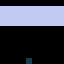
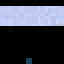

In [12]:
analyze_svd_reconstruction(observations, rgm_agent)

In [48]:
from atari.common import make_game, game_config, ObservationType

env = make_game(game_config("Breakout", ObservationType.MINI))
env.unwrapped.game.sticky_action_prob = 0.0

observation , info = env.reset(seed=3)
rgm_agent.reset()

terminated = False
truncated = False
step = 0
episode_reward = 0.0

infos = []
for i in tqdm(range(100)):
    observation = resize(render(observation))

    action, info = rgm_agent.act(observation)
    infos.append(info)

    if terminated or truncated:
        break

    observation, reward, terminated, truncated, _ = env.step(action)
    episode_reward += reward

    step += 1

100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


In [49]:
from rgm.utils import *

play

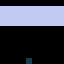

In [50]:
show_gameplay(infos)

play,reconstructions,preferences,attention

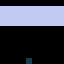
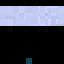
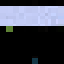
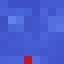

In [67]:
analyze_gameplay(infos, rgm_agent)


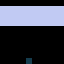
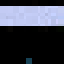

In [17]:
compare_ogm_reconstruction(infos[0]["observation"], rgm_agent)

0,1

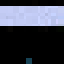
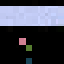

In [18]:
idx = [0, 1]
show_rgm_generation(idx, rgm_agent)

0 (1.0)

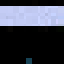

In [19]:
observations = jnp.stack([infos[i]["observation"] for i in range(4)], axis=0)
show_rgm_inferred_state(observations, rgm_agent)

preference,action 0 (0.00),action 1 (0.00),action 2 (0.99)

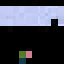
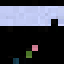
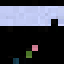
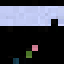

In [40]:
a, u, mi = analyze_planning(infos[15], rgm_agent)

In [42]:
upp = u.reshape(3, 8, 8)

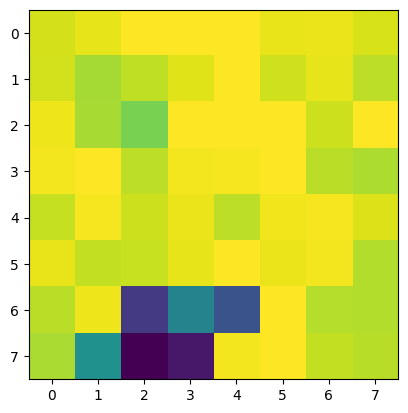

In [43]:
import matplotlib.pyplot as plt
plt.imshow(upp[0])

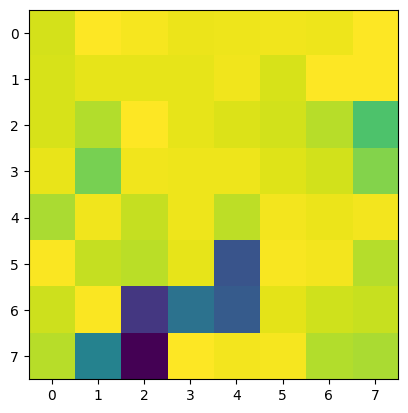

In [44]:
plt.imshow(upp[1])

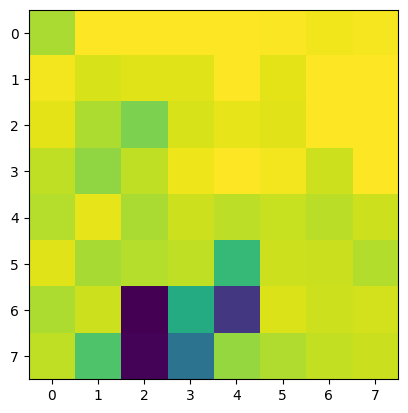

In [45]:
plt.imshow(upp[2])

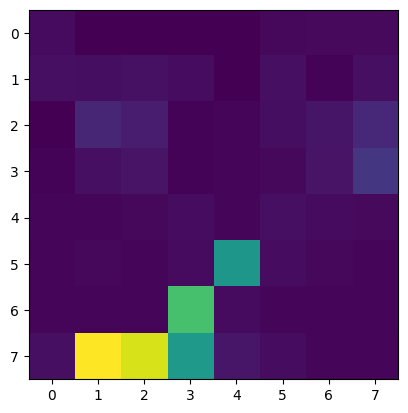

In [46]:
plt.imshow(mi.reshape(8,8))